In [1]:
!pip install -q pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output

In [3]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [4]:
import tensorflow as tf
tf.random.set_seed(123)

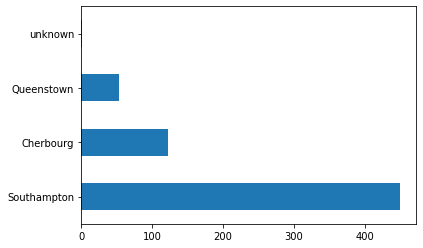

In [5]:
dftrain['embark_town'].value_counts().plot(kind='barh')
plt.show()

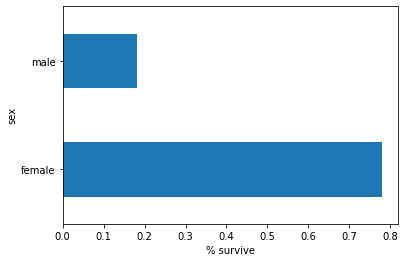

In [6]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
plt.show()

Gradient Boosting 추정기는 숫자 및 범주 기능을 모두 활용할 수 있습니다. 특성 열은 모든 TensorFlow 추정기와 함께 작동하며 그 목적은 모델링에 사용되는 특성을 정의하는 것입니다. 또한 원-핫 인코딩, 정규화 및 버킷 화와 같은 일부 기능 엔지니어링 기능을 제공합니다. 이 자습서에서 CATEGORICAL_COLUMNS 의 필드는 범주 형 열에서 원-핫 인코딩 된 열 ( 표시기 열 )로 변환됩니다.

In [7]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

In [9]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


다음으로 입력 함수를 만들어야합니다. 이는 훈련과 추론을 위해 데이터를 모델로 읽어들이는 방법을 지정합니다. tf.data API의 from_tensor_slices 메서드를 사용하여 Pandas에서 직접 데이터를 읽습니다. 이는 더 작은 메모리 내 데이터 세트에 적합합니다. 더 큰 데이터 세트의 경우 tf.data API는 다양한 파일 형식 ( csv 포함)을 지원하므로 메모리에 맞지 않는 데이터 세트를 처리 할 수 있습니다.
- from_tensor_slices: memory 내에서 해결 가능 할때
- tf.data...: io


In [15]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [16]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


다음으로 Boosted Trees 모델을 훈련시켜 보겠습니다. 부스트 트리의 경우 회귀 ( BoostedTreesRegressor ) 및 분류 ( BoostedTreesClassifier )가 지원됩니다. 목표는 클래스 생존 여부를 예측하는 BoostedTreesClassifier 를 사용합니다.

In [17]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.833333
accuracy_baseline         0.625000
auc                       0.874778
auc_precision_recall      0.859794
average_loss              0.406492
label/mean                0.375000
loss                      0.406492
precision                 0.795699
prediction/mean           0.385033
recall                    0.747475
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdy62yu1r/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


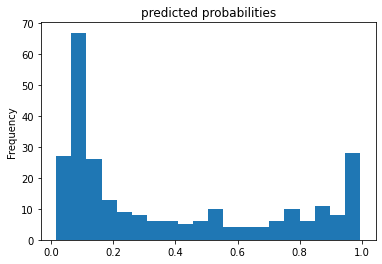

In [18]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

In [21]:
print(y_eval, probs)

0      0
1      0
2      1
3      1
4      1
      ..
259    1
260    0
261    0
262    0
263    1
Name: survived, Length: 264, dtype: int64 0      0.104742
1      0.301823
2      0.374938
3      0.398744
4      0.175549
         ...   
259    0.614573
260    0.075746
261    0.110424
262    0.096798
263    0.552391
Length: 264, dtype: float64


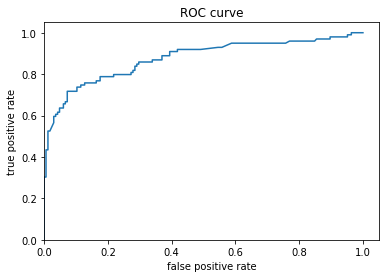

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()